In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from utils import *
update_plot_defaults()
%load_ext autoreload
%autoreload 2

# Na channels: inactivation

## 1. Choose the data file you want to analyze

In [2]:
pathToData = "data/"
data_folders = glob(pathToData+"*") # The glob function helps you filter your files
print("Data folders:")
data_folders

Data folders:


['data/K_channels',
 'data/single_channel_recordings',
 'data/20240610_Ca+channel',
 'data/20240612_Slice_day_1',
 'data/Protocol Day 1.pro',
 'data/Voltage Clamp 1 MEO.pro',
 'data/Current Clamp 1.pro',
 'data/Fig_Cav',
 'data/20240618_opto',
 'data/Voltage Clamp 1.pro',
 'data/example_HEKA.dat',
 'data/Na_channels',
 'data/Data Presentation - CSHL Ion Channels.pptx',
 'data/link_to_data.txt',
 'data/20240614_Slice_evoked',
 'data/20240615_LFP',
 'data/20240617_LTP',
 'data/20240608_Na+channel',
 'data/striatum',
 'data/20240611_SingleChannel',
 'data/Fig_Kv']

In [4]:
folder = 'data/Na_channels'
data_files = glob(folder +"/*.abf")
print(folder)
data_files

data/Na_channels


['data/Na_channels/nav18-iv.abf',
 'data/Na_channels/nav18-ssinact.abf',
 'data/Na_channels/nav18-nav_recovery.abf',
 'data/Na_channels/NAV_Tho(1)_21309013.abf',
 'data/Na_channels/NAV_Cerv(3)_22712021.abf',
 'data/Na_channels/NAV_Tho(2)_21309018.abf',
 'data/Na_channels/NAV_Cerv(1)_22712019.abf',
 'data/Na_channels/NAV_Cerv(2)_22712020.abf',
 'data/Na_channels/NAV_Lomb(1)_22919024.abf',
 'data/Na_channels/NAV_Lomb(2)_22919023.abf']

In [7]:
data_file = 'data/Na_channels/nav18-ssinact.abf'

(40, 2, 55000)
(55000,)
freq: 99999.99999999999 Hz


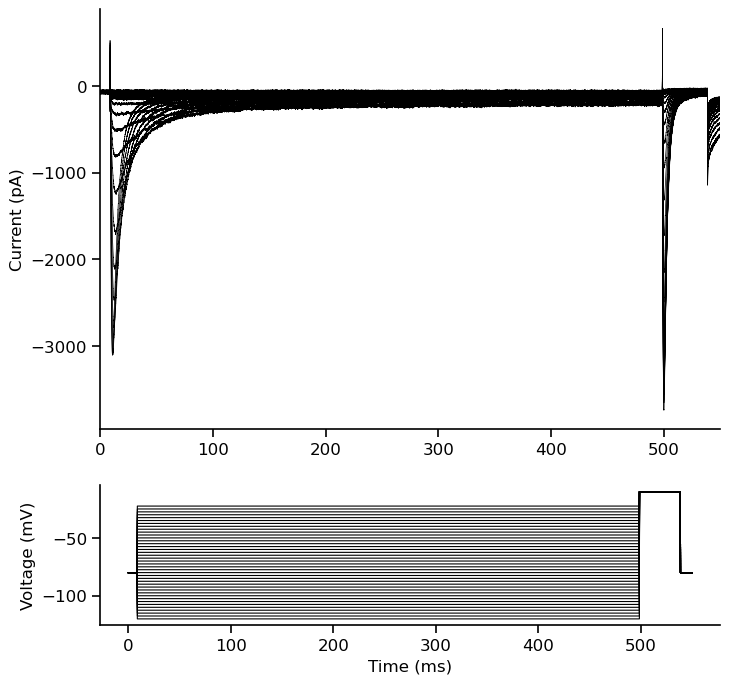

In [19]:
## Extract the sweeps, time and sampling frequency:
sweeps, sweeps_time, sampling_freq = get_sweeps(data_file)

print(sweeps.shape)
print(sweeps_time.shape)
print(f"freq: {sampling_freq} Hz")

current_traces = sweeps[:, 0, :]
voltage_traces = sweeps[:, 1, :]
plot_traces(sweeps_time, current_traces, voltage_traces)
plt.show()


## 2. Plot the traces to get an overview of the data

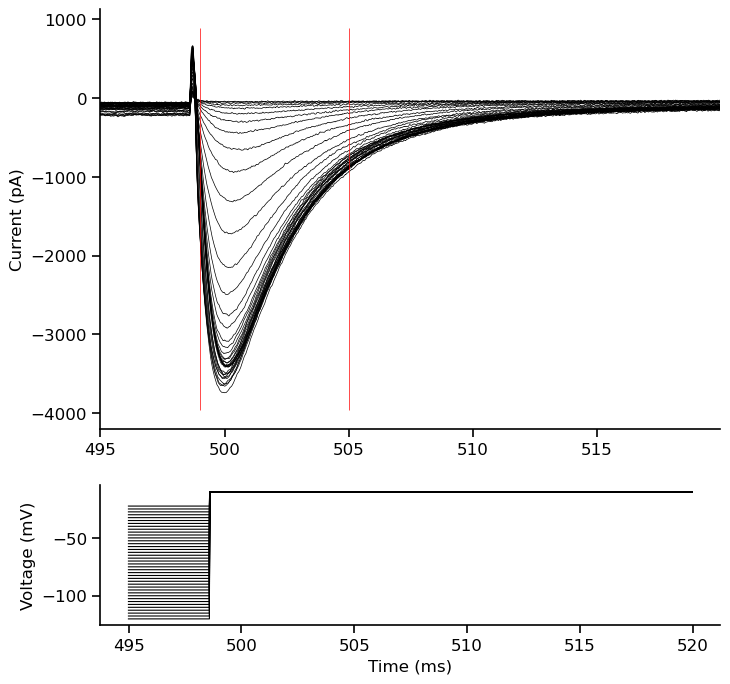

In [ ]:
start_time = 495   # milliseconds
end_time   = 520   # milliseconds (enter -1 to get the end of the sweep)

marker_1 = 499 # milliseconds
marker_2 = 505 # milliseconds

current_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=0)
voltage_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=1)

plot_traces(time_in_window, current_traces, voltage_traces, marker_1, marker_2)
plt.show()

## 3. Select what you want to measure:
- define the time window(s) of interest
- define what you want to measure (e.g. mean or peak voltage/current)

### 3.1. Optional: apply baseline correction

In [29]:
# # 1. Measure baseline
# start_time = 0 # milliseconds
# end_time = 0.5 # milliseconds
# measurement_type = 'mean' # Options: 'mean', 'max', 'min'

# baseline_voltage, baseline_current = get_step_measurements(sweeps, sweeps_time, start_time, end_time, sampling_freq, measurement_type)

# num_traces = sweeps.shape[0]
# for i in range(num_traces):
#     # sweeps[i,1] -= baseline_voltage[i]
#     sweeps[i,0] -= baseline_current[i]

# plot_traces(time_in_window, current_traces, voltage_traces, marker_1, marker_2)

### 3.2. Measure currents/voltage steps

Sigmoid Fit parameters:
ymax: -0.985, ymin: 0.993, x_half: -49.900, slope: 0.193


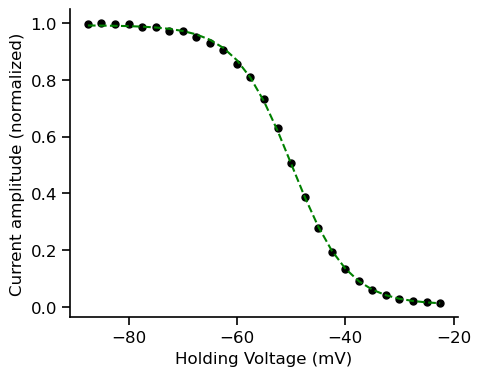

In [30]:
start_time = marker_1 # milliseconds
end_time = marker_2 # milliseconds
measurement_type = 'peak' # Options: 'mean', 'max', 'min', 'peak'

_, current_steps = get_step_measurements(sweeps, sweeps_time, start_time, end_time, sampling_freq, measurement_type)

# Here we want to measure the holding voltages in the first phase of the step protocol.
voltage_steps, _ = get_step_measurements(sweeps, sweeps_time, start_time=480, end_time=490, sampling_freq=sampling_freq, measurement_type='mean')

# Remove bad sweeps
current_steps = current_steps[13:]
voltage_steps = voltage_steps[13:]

# Normalize to the biggest current
current_steps /= np.min(current_steps)  # Normalize current steps to the minimum value

# Plot the normalized current steps against the holding voltages
plt.figure(figsize=(5, 4))
plt.plot(voltage_steps, current_steps, 'o', color='black', markersize=5)
plt.xlabel('Holding Voltage (mV)')
plt.ylabel('Current amplitude (normalized)')

# Optional: fit a sigmoid to the points
from scipy.optimize import curve_fit
def sigmoid(x, ymax, x0, slope, ymin):
    return ymax / (1 + np.exp(-slope * (x - x0))) + ymin
p0 = [max(current_steps), np.median(voltage_steps), 1, min(current_steps)]
popt, pcov = curve_fit(sigmoid, voltage_steps, current_steps, p0=p0)
plt.plot(voltage_steps, sigmoid(voltage_steps, *popt), linestyle='--', color='g', label='Fit')
print("Sigmoid Fit parameters:")
print(f"ymax: {popt[0]:.3f}, ymin: {popt[3]:.3f}, x_half: {popt[1]:.3f}, slope: {popt[2]:.3f}")
